In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

In [5]:
def get_data():
    df = pd.read_csv('shm_data/tension.csv')
    x_train = list(df.values)
    x_train.pop(0)
    x_train = np.array(x_train)
    
    mean = x_train.mean()
    std = x_train.std()
    
    x_train = (x_train - mean) / std
    
    y_train = np.array([i for i in range(40) for j in range(100)])
    
    print(x_train.shape, y_train.shape)
    
    return x_train, y_train, mean, std

In [6]:
def construct_model():
    model = Sequential([
            Flatten(input_shape=(40,)),
            Dense(128, activation='relu'),
            Dense(128, activation='relu'),
            Dense(128, activation='relu'),
            Dense(40, activation='softmax'),
        ])
        
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [7]:
def training_model(iteration, epochs, batch_size, shuffle):
    weights_list = []
    
    for i in range(iteration):
        print('Iteration {}'.format(i+1))
        
        model = construct_model()
        model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, shuffle=shuffle, verbose=0)
        
        weights = model.get_weights()
        weights_list.append(weights[-1])
        
    return weights_list

In [8]:
def sort_weights_list(weights_list):
    wei_list = []
    for i, weights in enumerate(weights_list):
        w_list = list(weights)
        w_list.sort(reverse=True)

        w_list2 = list(weights)

        print('Epoch {}'.format(i+1))
        we_list = []
        for i in range(len(weights)):
            we_list.append(w_list2.index(w_list[i]))
            print(w_list2.index(w_list[i]), end = ' ')
        print('')
        wei_list.append(we_list)
    return wei_list

In [11]:
def score_list(wei_list):
    scores = [0 for i in range(40)]
    for weights in wei_list:
        score = 40
        for w in weights:
            scores[w] += score
            score -= 1
    return scores

In [14]:
def importance_score(scores):
    importance = []
    temp = list(scores)
    temp.sort(reverse=True)

    for i in range(40):
        importance.append(scores.index(temp[i]))
    return importance

In [23]:
def mean_weights(weights_list):
    w_list = [[] for i in range(40)]
    for weights in weights_list:
        for i, w in enumerate(weights):
            w_list[i].append(w)

    means = []
    for w in w_list:
        w = np.array(w)
        means.append(w.mean())
    return means

In [16]:
def importance_mean(means):
    importance = []
    temp = list(means)
    temp.sort(reverse=True)

    for i in range(40):
        importance.append(means.index(temp[i]))
    return importance

In [25]:
def get_data_importance(importance, x_train):
    x_temp = []
    for x in x_train:
        t = []
        for imp in importance:
            t.append(x[imp])
        x_temp.append(t)
    x_temp = np.array(x_temp)
    print(x_temp.shape)
    return x_temp

In [18]:
def construct_model_importance(shape):
    model = Sequential([
            Flatten(input_shape=(shape,)),
            Dense(128, activation='relu'),
            Dense(128, activation='relu'),
            Dense(128, activation='relu'),
            Dense(40, activation='softmax'),
        ])
        
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [19]:
def accuracy_list(importance, x_train, y_train):
    accuracy_list = []
    for i in range(40):
        imp = importance[:i+1]

        x_train_t = get_data_importance(imp, x_train)
        model = construct_model_importance(x_train_t.shape[1])
        history = model.fit(x_train_t, y_train, epochs = 200, batch_size = 100, verbose = 0)
        accuracy_list.append(history.history['accuracy'][-1])
    return accuracy_list

In [20]:
def accuracy_list_by_one(importance, x_train, y_train):
    accuracy_list = []
    for i in range(40):
        imp = [importance[i]]

        x_train_t = get_data_importance(imp, x_train)
        model = construct_model_importance(x_train_t.shape[1])
        history = model.fit(x_train_t, y_train, epochs = 200, batch_size = 100, verbose = 0)
        accuracy_list.append(history.history['accuracy'][-1])
    return accuracy_list

In [21]:
def plot(x, y, title, x_legend, y_legend):
    plt.title(title)
    plt.plot(x)
    plt.plot(y)
    plt.xlabel('cable')
    plt.ylabel('accuracy')
    plt.legend([x_legend, y_legend])
    plt.show()

In [28]:
acc_dic = {}
acc_dic['C1'] = []
acc_dic['C2'] = []
acc_dic['C3'] = []
acc_dic['v2C1'] = []
acc_dic['v2C2'] = []
acc_dic['v2C3'] = []
acc_dic

{'C1': [], 'C2': [], 'C3': [], 'v2C1': [], 'v2C2': [], 'v2C3': []}

In [29]:
x_train, y_train, mean, std = get_data()
weights_list = training_model(iteration=10, epochs=200, batch_size=100, shuffle=True)
print('\n----Training Finish----\n')
wei_list = sort_weights_list(weights_list)
scores = score_list(wei_list)
imp_score = importance_score(scores)
means = mean_weights(weights_list)
imp_mean = importance_mean(means)
print('\n----Importance----\n')
accuracy_score = accuracy_list(imp_score, x_train, y_train)
accuracy_mean = accuracy_list(imp_mean, x_train, y_train)
print('\n----Accuracy----\n')
imp_score, imp_mean = imp_score.reverse(), imp_mean.reverse()
accuracy_score_reverse = accuracy_list(imp_score, x_train, y_train)
accuracy_mean_reverse = accuracy_list(imp_mean, x_train, y_train)
print('\n----Reverse Accuracy----\n')
accuracy_one_score = accuracy_list_by_one(imp_score, x_train, y_train)
accuracy_one_mean = accuracy_list_by_one(imp_mean, x_train, y_train)
print('\n----One Accuracy----\n')
plot(accuracy_score, accuracy_mean, 'Score-Mean', 'Score', 'Mean')
plot(accuracy_score, accuracy_mean, 'Reverse', 'Score', 'Mean')
plot(accuracy_score, accuracy_mean, 'One', 'Score', 'Mean')

acc_dic['C1'].append(accuracy_score)
acc_dic['C1'].append(accuracy_mean)
acc_dic['C1'].append(accuracy_score_reverse)
acc_dic['C1'].append(accuracy_mean_reverse)
acc_dic['C1'].append(accuracy_one_score)
acc_dic['C1'].append(accuracy_one_mean)

(4000, 40) (4000,)
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10

----Training Finish----

Epoch 1
7 2 4 22 26 12 25 15 5 24 38 29 35 17 10 18 30 28 32 20 31 14 34 19 36 9 13 39 1 37 33 6 23 8 16 11 21 0 27 3 
Epoch 2
14 21 36 25 38 12 31 16 5 2 19 30 24 35 26 9 18 8 27 29 22 23 6 10 34 4 28 15 20 17 39 3 13 0 33 32 1 7 37 11 
Epoch 3
25 34 35 28 37 14 6 5 15 32 31 18 29 26 2 22 3 24 23 1 9 16 11 20 12 10 8 36 19 4 38 0 39 33 21 13 7 30 17 27 
Epoch 4
25 28 0 21 12 15 8 5 26 9 14 23 18 2 24 4 1 11 30 3 27 32 34 33 17 6 22 37 35 36 39 38 7 19 13 10 31 29 16 20 
Epoch 5
25 34 9 16 5 3 36 23 10 1 35 4 28 32 11 24 19 13 6 7 38 39 30 33 20 14 27 26 31 22 0 37 18 21 2 8 15 12 17 29 
Epoch 6
25 5 16 36 9 34 11 2 7 3 32 15 6 23 0 19 4 29 39 35 12 30 27 20 33 14 28 8 31 24 37 10 38 22 21 17 26 18 1 13 
Epoch 7
11 2 5 39 18 15 21 30 14 3 28 6 25 19 35 23 37 16 8 29 31 13 34 9 26 27 24 36 22 0 33 32 1 4 10 20 17 7 12 38 
E

TypeError: 'NoneType' object is not subscriptable

(4000, 1)
(4000, 2)
(4000, 3)
(4000, 4)
(4000, 5)
(4000, 6)
(4000, 7)
(4000, 8)
(4000, 9)
(4000, 10)
(4000, 11)
(4000, 12)
(4000, 13)
(4000, 14)
(4000, 15)
(4000, 16)
(4000, 17)
(4000, 18)
(4000, 19)
(4000, 20)
(4000, 21)
(4000, 22)
(4000, 23)
(4000, 24)
(4000, 25)
(4000, 26)
(4000, 27)
(4000, 28)
(4000, 29)
(4000, 30)
(4000, 31)
(4000, 32)
(4000, 33)
(4000, 34)
(4000, 35)
(4000, 36)
(4000, 37)
(4000, 38)
(4000, 39)
(4000, 40)
(4000, 1)
(4000, 2)
(4000, 3)
(4000, 4)
(4000, 5)
(4000, 6)
(4000, 7)
(4000, 8)
(4000, 9)
(4000, 10)
(4000, 11)
(4000, 12)
(4000, 13)
(4000, 14)
(4000, 15)
(4000, 16)
(4000, 17)
(4000, 18)
(4000, 19)
(4000, 20)
(4000, 21)
(4000, 22)
(4000, 23)
(4000, 24)
(4000, 25)
(4000, 26)
(4000, 27)
(4000, 28)
(4000, 29)
(4000, 30)
(4000, 31)
(4000, 32)
(4000, 33)
(4000, 34)
(4000, 35)
(4000, 36)
(4000, 37)
(4000, 38)
(4000, 39)
(4000, 40)

----Reverse Accuracy----

(4000, 1)
(4000, 1)
(4000, 1)
(4000, 1)
(4000, 1)
(4000, 1)
(4000, 1)
(4000, 1)
(4000, 1)
(4000, 1)
(4000, 1)
(

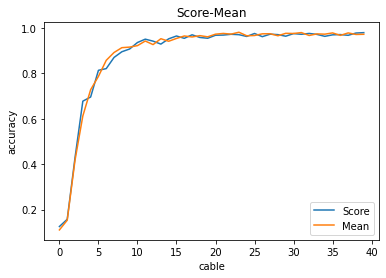

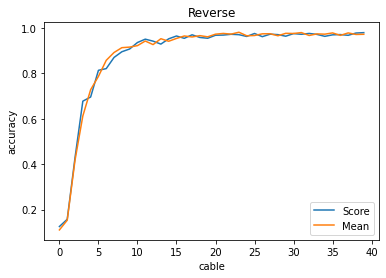

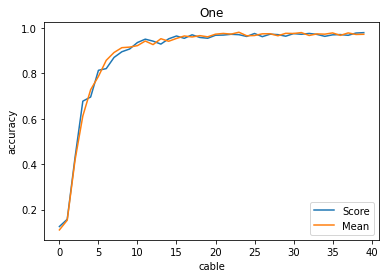

In [40]:
imp_score = importance_score(scores)
imp_mean = importance_mean(means)
imp_score.reverse()
imp_mean.reverse()
accuracy_score_reverse = accuracy_list(imp_score, x_train, y_train)
accuracy_mean_reverse = accuracy_list(imp_mean, x_train, y_train)
print('\n----Reverse Accuracy----\n')
imp_score.reverse()
imp_mean.reverse()
accuracy_one_score = accuracy_list_by_one(imp_score, x_train, y_train)
accuracy_one_mean = accuracy_list_by_one(imp_mean, x_train, y_train)
print('\n----One Accuracy----\n')
plot(accuracy_score, accuracy_mean, 'Score-Mean', 'Score', 'Mean')
plot(accuracy_score, accuracy_mean, 'Reverse', 'Score', 'Mean')
plot(accuracy_score, accuracy_mean, 'One', 'Score', 'Mean')

acc_dic['C1'].append(accuracy_score)
acc_dic['C1'].append(accuracy_mean)
acc_dic['C1'].append(accuracy_score_reverse)
acc_dic['C1'].append(accuracy_mean_reverse)
acc_dic['C1'].append(accuracy_one_score)
acc_dic['C1'].append(accuracy_one_mean)

In [ ]:
x_train, y_train, mean, std = get_data()
weights_list = training_model(iteration=10, epochs=200, batch_size=100, shuffle=True)
print('\n----Training Finish----\n')
wei_list = sort_weights_list(weights_list)
scores = score_list(wei_list)
imp_score = importance_score(scores)
means = mean_weights(weights_list)
imp_mean = importance_mean(means)
print('\n----Importance----\n')
accuracy_score = accuracy_list(imp_score, x_train, y_train)
accuracy_mean = accuracy_list(imp_mean, x_train, y_train)
print('\n----Accuracy----\n')
imp_score.reverse()
imp_mean.reverse()
accuracy_score_reverse = accuracy_list(imp_score, x_train, y_train)
accuracy_mean_reverse = accuracy_list(imp_mean, x_train, y_train)
print('\n----Reverse Accuracy----\n')
imp_score.reverse()
imp_mean.reverse()
accuracy_one_score = accuracy_list_by_one(imp_score, x_train, y_train)
accuracy_one_mean = accuracy_list_by_one(imp_mean, x_train, y_train)
print('\n----One Accuracy----\n')
plot(accuracy_score, accuracy_mean, 'Score-Mean', 'Score', 'Mean')
plot(accuracy_score, accuracy_mean, 'Reverse', 'Score', 'Mean')
plot(accuracy_score, accuracy_mean, 'One', 'Score', 'Mean')

acc_dic['C2'].append(accuracy_score)
acc_dic['C2'].append(accuracy_mean)
acc_dic['C2'].append(accuracy_score_reverse)
acc_dic['C2'].append(accuracy_mean_reverse)
acc_dic['C2'].append(accuracy_one_score)
acc_dic['C2'].append(accuracy_one_mean)

In [ ]:
x_train, y_train, mean, std = get_data()
weights_list = training_model(iteration=10, epochs=200, batch_size=100, shuffle=True)
print('\n----Training Finish----\n')
wei_list = sort_weights_list(weights_list)
scores = score_list(wei_list)
imp_score = importance_score(scores)
means = mean_weights(weights_list)
imp_mean = importance_mean(means)
print('\n----Importance----\n')
accuracy_score = accuracy_list(imp_score, x_train, y_train)
accuracy_mean = accuracy_list(imp_mean, x_train, y_train)
print('\n----Accuracy----\n')
imp_score.reverse()
imp_mean.reverse()
accuracy_score_reverse = accuracy_list(imp_score, x_train, y_train)
accuracy_mean_reverse = accuracy_list(imp_mean, x_train, y_train)
print('\n----Reverse Accuracy----\n')
imp_score.reverse()
imp_mean.reverse()
accuracy_one_score = accuracy_list_by_one(imp_score, x_train, y_train)
accuracy_one_mean = accuracy_list_by_one(imp_mean, x_train, y_train)
print('\n----One Accuracy----\n')
plot(accuracy_score, accuracy_mean, 'Score-Mean', 'Score', 'Mean')
plot(accuracy_score, accuracy_mean, 'Reverse', 'Score', 'Mean')
plot(accuracy_score, accuracy_mean, 'One', 'Score', 'Mean')

acc_dic['C3'].append(accuracy_score)
acc_dic['C3'].append(accuracy_mean)
acc_dic['C3'].append(accuracy_score_reverse)
acc_dic['C3'].append(accuracy_mean_reverse)
acc_dic['C3'].append(accuracy_one_score)
acc_dic['C3'].append(accuracy_one_mean)

In [ ]:
x_train, y_train, mean, std = get_data()
weights_list = training_model(iteration=10, epochs=300, batch_size=100, shuffle=True)
print('\n----Training Finish----\n')
wei_list = sort_weights_list(weights_list)
scores = score_list(wei_list)
imp_score = importance_score(scores)
means = mean_weights(weights_list)
imp_mean = importance_mean(means)
print('\n----Importance----\n')
accuracy_score = accuracy_list(imp_score, x_train, y_train)
accuracy_mean = accuracy_list(imp_mean, x_train, y_train)
print('\n----Accuracy----\n')
imp_score.reverse()
imp_mean.reverse()
accuracy_score_reverse = accuracy_list(imp_score, x_train, y_train)
accuracy_mean_reverse = accuracy_list(imp_mean, x_train, y_train)
print('\n----Reverse Accuracy----\n')
imp_score.reverse()
imp_mean.reverse()
accuracy_one_score = accuracy_list_by_one(imp_score, x_train, y_train)
accuracy_one_mean = accuracy_list_by_one(imp_mean, x_train, y_train)
print('\n----One Accuracy----\n')
plot(accuracy_score, accuracy_mean, 'Score-Mean', 'Score', 'Mean')
plot(accuracy_score, accuracy_mean, 'Reverse', 'Score', 'Mean')
plot(accuracy_score, accuracy_mean, 'One', 'Score', 'Mean')

acc_dic['v2C1'].append(accuracy_score)
acc_dic['v2C1'].append(accuracy_mean)
acc_dic['v2C1'].append(accuracy_score_reverse)
acc_dic['v2C1'].append(accuracy_mean_reverse)
acc_dic['v2C1'].append(accuracy_one_score)
acc_dic['v2C1'].append(accuracy_one_mean)

In [ ]:
x_train, y_train, mean, std = get_data()
weights_list = training_model(iteration=10, epochs=300, batch_size=100, shuffle=True)
print('\n----Training Finish----\n')
wei_list = sort_weights_list(weights_list)
scores = score_list(wei_list)
imp_score = importance_score(scores)
means = mean_weights(weights_list)
imp_mean = importance_mean(means)
print('\n----Importance----\n')
accuracy_score = accuracy_list(imp_score, x_train, y_train)
accuracy_mean = accuracy_list(imp_mean, x_train, y_train)
print('\n----Accuracy----\n')
imp_score.reverse()
imp_mean.reverse()
accuracy_score_reverse = accuracy_list(imp_score, x_train, y_train)
accuracy_mean_reverse = accuracy_list(imp_mean, x_train, y_train)
print('\n----Reverse Accuracy----\n')
imp_score.reverse()
imp_mean.reverse()
accuracy_one_score = accuracy_list_by_one(imp_score, x_train, y_train)
accuracy_one_mean = accuracy_list_by_one(imp_mean, x_train, y_train)
print('\n----One Accuracy----\n')
plot(accuracy_score, accuracy_mean, 'Score-Mean', 'Score', 'Mean')
plot(accuracy_score, accuracy_mean, 'Reverse', 'Score', 'Mean')
plot(accuracy_score, accuracy_mean, 'One', 'Score', 'Mean')

acc_dic['v2C2'].append(accuracy_score)
acc_dic['v2C2'].append(accuracy_mean)
acc_dic['v2C2'].append(accuracy_score_reverse)
acc_dic['v2C2'].append(accuracy_mean_reverse)
acc_dic['v2C2'].append(accuracy_one_score)
acc_dic['v2C2'].append(accuracy_one_mean)

In [ ]:
x_train, y_train, mean, std = get_data()
weights_list = training_model(iteration=10, epochs=300, batch_size=100, shuffle=True)
print('\n----Training Finish----\n')
wei_list = sort_weights_list(weights_list)
scores = score_list(wei_list)
imp_score = importance_score(scores)
means = mean_weights(weights_list)
imp_mean = importance_mean(means)
print('\n----Importance----\n')
accuracy_score = accuracy_list(imp_score, x_train, y_train)
accuracy_mean = accuracy_list(imp_mean, x_train, y_train)
print('\n----Accuracy----\n')
imp_score.reverse()
imp_mean.reverse()
accuracy_score_reverse = accuracy_list(imp_score, x_train, y_train)
accuracy_mean_reverse = accuracy_list(imp_mean, x_train, y_train)
print('\n----Reverse Accuracy----\n')
imp_score.reverse()
imp_mean.reverse()
accuracy_one_score = accuracy_list_by_one(imp_score, x_train, y_train)
accuracy_one_mean = accuracy_list_by_one(imp_mean, x_train, y_train)
print('\n----One Accuracy----\n')
plot(accuracy_score, accuracy_mean, 'Score-Mean', 'Score', 'Mean')
plot(accuracy_score, accuracy_mean, 'Reverse', 'Score', 'Mean')
plot(accuracy_score, accuracy_mean, 'One', 'Score', 'Mean')

acc_dic['v2C3'].append(accuracy_score)
acc_dic['v2C3'].append(accuracy_mean)
acc_dic['v2C3'].append(accuracy_score_reverse)
acc_dic['v2C3'].append(accuracy_mean_reverse)
acc_dic['v2C3'].append(accuracy_one_score)
acc_dic['v2C3'].append(accuracy_one_mean)

In [42]:
acc_dic['C1']

[[0.12549999356269836,
  0.15725000202655792,
  0.42899999022483826,
  0.6779999732971191,
  0.6962500214576721,
  0.8140000104904175,
  0.8215000033378601,
  0.8707500100135803,
  0.8957499861717224,
  0.9079999923706055,
  0.9365000128746033,
  0.9512500166893005,
  0.9424999952316284,
  0.9294999837875366,
  0.952750027179718,
  0.9652500152587891,
  0.9549999833106995,
  0.9704999923706055,
  0.9587500095367432,
  0.9552500247955322,
  0.968500018119812,
  0.9692500233650208,
  0.9727500081062317,
  0.9710000157356262,
  0.9632499814033508,
  0.9762499928474426,
  0.9622499942779541,
  0.9732499718666077,
  0.9712499976158142,
  0.9642500281333923,
  0.9757500290870667,
  0.9727500081062317,
  0.9764999747276306,
  0.9722499847412109,
  0.9637500047683716,
  0.9702500104904175,
  0.9714999794960022,
  0.9682499766349792,
  0.9782500267028809,
  0.9800000190734863],
 [0.11050000041723251,
  0.15324999392032623,
  0.4180000126361847,
  0.6127499938011169,
  0.7285000085830688,
  0.78